In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from datetime import datetime
from math import sin, cos, sqrt, atan2, radians

In [2]:
# First lets read the data into table format so that we can draw some insight
# Next we will clean the data based on some observations.
data = pd.read_csv('train.csv', nrows=10000000)

In [3]:
# Lets see what kind of data we have
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398016e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


In [4]:
data[(data['passenger_count'] > 8) | (data['passenger_count'] <= 0)].shape

(35347, 8)

(-72.03, -75.75)

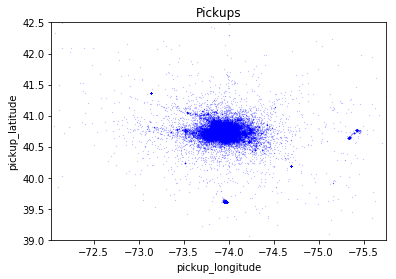

In [5]:
# First lets check the variation of latitude and longitude by drawing the scatter plot taking 
# very relaxed boundary conditions
lat_border = (39, 42.5)
long_border = (-72.03, -75.75)
data.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude', 
       color='blue', s=.02, alpha=.6)
plt.title("Pickups")
plt.ylim(lat_border)
plt.xlim(long_border)

(-72.03, -75.75)

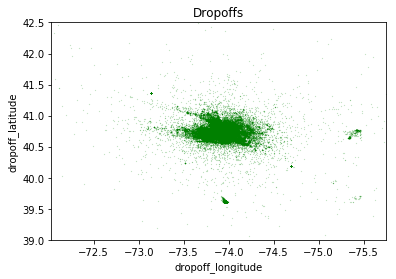

In [6]:
lat_border = (39, 42.5)
long_border = (-72.03, -75.75)
data.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude', 
       color='green', s=.02, alpha=.6)
plt.title("Dropoffs")
plt.ylim(lat_border)
plt.xlim(long_border)

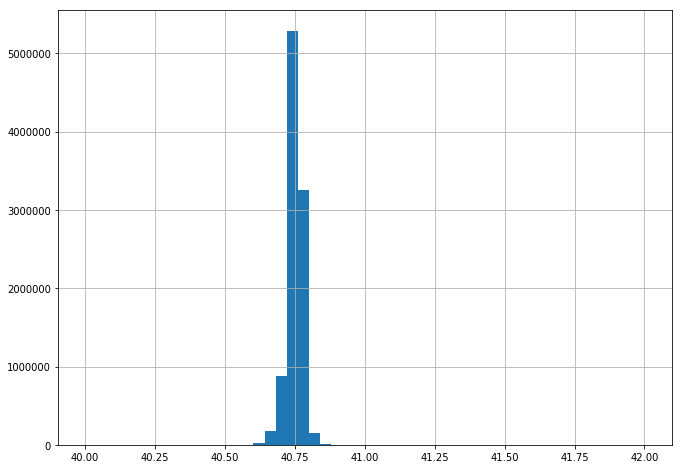

In [7]:
#Plotting histograms as well to take a more closer look
data[(data.pickup_latitude > 40) & (data.pickup_latitude < 42)].pickup_latitude.hist(bins=50, figsize=(11,8))

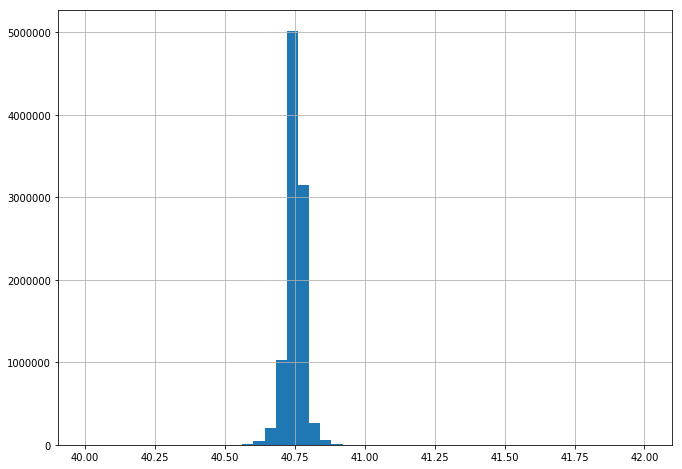

In [8]:
data[(data.dropoff_latitude > 40) & (data.dropoff_latitude < 42)].dropoff_latitude.hist(bins=50, figsize=(11,8))

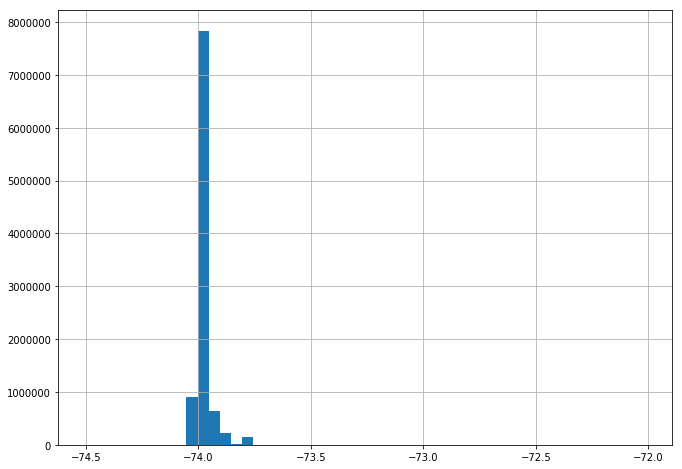

In [9]:
data[(data.pickup_longitude > -74.5) & (data.pickup_longitude < -72)].pickup_longitude.hist(bins=50, figsize=(11,8))

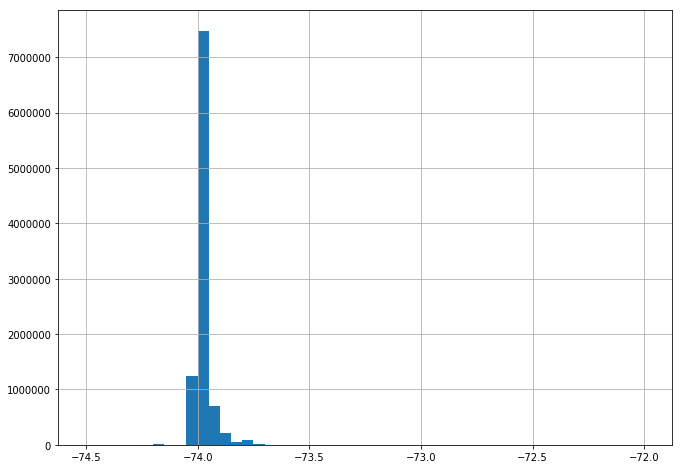

In [10]:
data[(data.dropoff_longitude > -74.5) & (data.dropoff_longitude < -72)].dropoff_longitude.hist(bins=50, figsize=(11,8))

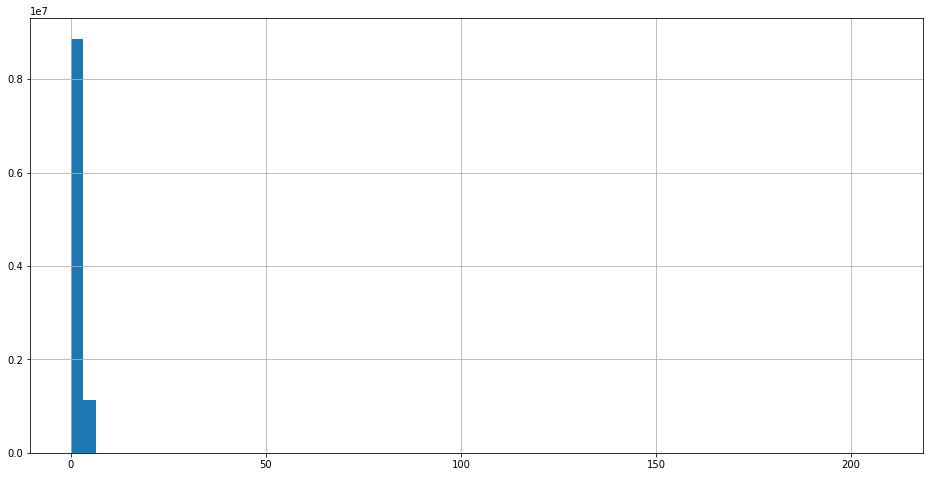

In [11]:
data['passenger_count'].hist(bins=64, figsize=(16,8))

In [12]:
# This method will be used to do the initial phase opf the data cleaning, 
# primarily outlier removals and some approximations.
def clean_data(df):
    # New york city has a central location cordinates of Latitude = 40.7128 and Longitude = 74.0060
    # Therefore we restrict the pickup and dropoff locations to avoid considering rides which
    # are lying outside the nyc area.
    nyc_min_latitude = 40.45
    nyc_max_latitude = 40.97
    nyc_min_longitude = -74.28
    nyc_max_longitude = -73.64
    
    # Removing null entries from the data
    df = df.dropna(how='any', axis = 'rows')
    
    # Removing entries for which pickup/ dropoff locations do not lie inside the nyc area
    df = df[(df['pickup_latitude'] >= nyc_min_latitude) & (df['pickup_latitude'] <= nyc_max_latitude)]
    df = df[(df['pickup_longitude'] >= nyc_min_longitude) & (df['pickup_longitude'] <= nyc_max_longitude)]
    df = df[(df['dropoff_latitude'] >= nyc_min_latitude) & (df['dropoff_latitude'] <= nyc_max_latitude)]
    df = df[(df['dropoff_longitude'] >= nyc_min_longitude) & (df['dropoff_longitude'] <= nyc_max_longitude)]
    
    # Clean entries which have passenger count greater than 8
    df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 8)]
    df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]
    return df

In [13]:
# Lets clean the data now to remove outliers and reduce our data to meaningful entries
data = clean_data(data)

In [14]:
data.shape

(9742396, 8)

In [15]:
stat = data.describe()

In [16]:
stat[['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude']]

,pickup_latitude,dropoff_latitude,pickup_longitude,dropoff_longitude
count,9.742396e+06,9.742396e+06,9.742396e+06,9.742396e+06
mean,4.075084e+01,4.075122e+01,-7.397550e+01,-7.397458e+01
std,2.695317e-02,3.080515e-02,3.453672e-02,3.400300e-02
min,4.045191e+01,4.045191e+01,-7.427998e+01,-7.427996e+01
25%,4.073655e+01,4.073559e+01,-7.399229e+01,-7.399158e+01
50%,4.075334e+01,4.075385e+01,-7.398211e+01,-7.398062e+01
75%,4.076751e+01,4.076838e+01,-7.396836e+01,-7.396540e+01
max,4.096982e+01,4.096999e+01,-7.364037e+01,-7.364002e+01


In [17]:
# There has been some reduction in the dataset. (Irrelevant data)
data.shape

(9742396, 8)

In [18]:
# This code has been took from stack_overflow and gives the 
# haversine distance between two points on the earth.

def get_euclidean_dist(loc_data):
    orig_lat , orig_lon, dest_lat, dest_lon = loc_data
                           
    radius = 6371    # This is a constant whose value is equal to Earth's radius
                           
    deltaLat = radians(dest_lat-orig_lat)
    deltaLon = radians(dest_lon-orig_lon)
    
    a = sin(deltaLat/2)**2 + cos(radians(orig_lat)) * cos(radians(dest_lat)) * sin(deltaLon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = radius * c
    return d

In [19]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [20]:
# Calculate the distance of each ride and make another entry in the dataset. This is an important field
# as fare amount is directly related to the distance travelled
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
data['distance'] = data[columns].apply(get_euclidean_dist, axis=1)

In [21]:
data.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,1.999157


In [22]:
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [23]:
pdt = data['pickup_datetime']

In [24]:
dtIdx = pd.DatetimeIndex(data['pickup_datetime'])

In [25]:
## This function will give us the absolute time of the day in minuites. 
## This is done to see if incorporating minutes in the time improves the correlation
def get_time_of_day(dateTime):
    dtIdx = pd.DatetimeIndex(dateTime)
    hours = dtIdx.hour
    minutes = dtIdx.minute
    absTimeofDay = (60*hours) + minutes
    return absTimeofDay

In [26]:
data['time'] = get_time_of_day(data['pickup_datetime'])

In [27]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,1046
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,1012
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,35
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,471


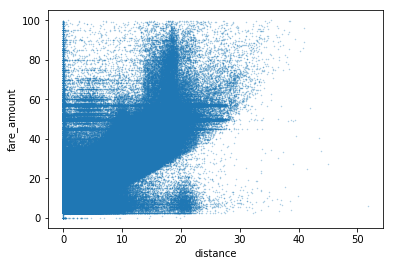

In [28]:
## Now we will see the relationship between the distance and the fare amount
## Since it is logical that a shorter ride will cost less than a longer one, 
# based on this data we can actually get some insightful information
data.plot(kind='scatter',x='distance',y='fare_amount', s=0.2, alpha=0.4)

In [29]:
# Preprocessing data to fetch some useful information regarding the time of the ride/ temporal analysis
data['year'] = pd.to_datetime(data['pickup_datetime']).dt.year
data['month'] = pd.to_datetime(data['pickup_datetime']).dt.month
data['day'] = pd.to_datetime(data['pickup_datetime']).dt.day
data['hour'] = pd.to_datetime(data['pickup_datetime']).dt.hour

Text(0.5,1,'Time of the day(min) vs distance')

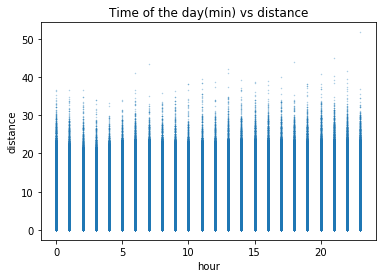

In [30]:
# 
data.plot(kind='scatter',x='hour',y='distance', s=0.2, alpha=0.4)
plt.title("Time of the day(min) vs distance")

Text(0.5,1,'Time of the day(min) vs fare amount')

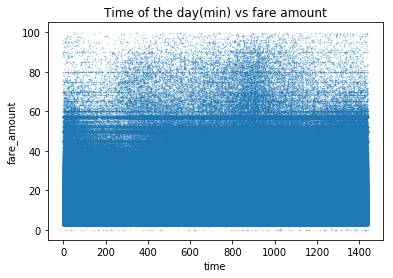

In [31]:
data.plot(kind='scatter',x='hour',y='fare_amount', s=0.2, alpha=0.4)
plt.title("Time of the day(min) vs fare amount")

In [32]:
data[['fare_amount','distance','time', 'hour']].corr()

,fare_amount,distance,time,hour
fare_amount,1.000000,0.875650,-0.017688,-0.017387
distance,0.875650,1.000000,-0.029439,-0.029175
time,-0.017688,-0.029439,1.000000,0.999019
hour,-0.017387,-0.029175,0.999019,1.000000


In [33]:
data['distance'].corr(data['fare_amount'])

0.8756501057696913

In [34]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time,year,month,day,hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,1046,2009,6,15,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,1012,2010,1,5,16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,1.389525,35,2011,8,18,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2.799270,270,2012,4,21,4
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,1.999157,471,2010,3,9,7


In [35]:
data['rate'] = data['fare_amount']/data['distance']

In [36]:
data = data[(data['rate'] > 0.5) & (data['rate'] < 10)]

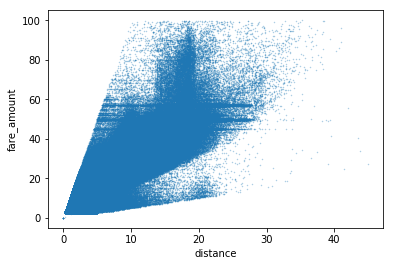

In [37]:
data.plot(kind='scatter',x='distance',y='fare_amount', s=0.2, alpha=0.4)

In [38]:
data['distance'].corr(data['fare_amount'])

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,time,year,month,day,hour,rate
count,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06,9.308183e+06
mean,1.129614e+01,-7.397577e+01,4.075094e+01,-7.397478e+01,4.075133e+01,1.689736e+00,3.432390e+00,8.408447e+02,2.011741e+03,6.260539e+00,1.571545e+01,1.352113e+01,4.093887e+00
std,9.160063e+00,3.373131e-02,2.655113e-02,3.319714e-02,3.062671e-02,1.304896e+00,3.562895e+00,3.922409e+02,1.865348e+00,3.435787e+00,8.688788e+00,6.530570e+00,1.562609e+00
min,1.000000e-02,-7.427994e+01,4.045191e+01,-7.427970e+01,4.045191e+01,1.000000e+00,1.353454e-03,0.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,5.000447e-01
25%,6.100000e+00,-7.399233e+01,4.073653e+01,-7.399160e+01,4.073551e+01,1.000000e+00,1.349316e+00,5.640000e+02,2.010000e+03,3.000000e+00,8.000000e+00,9.000000e+00,2.941933e+00
50%,8.500000e+00,-7.398216e+01,4.075331e+01,-7.398061e+01,4.075383e+01,1.000000e+00,2.247614e+00,8.810000e+02,2.012000e+03,6.000000e+00,1.600000e+01,1.400000e+01,3.760272e+00
75%,1.250000e+01,-7.396855e+01,4.076767e+01,-7.396549e+01,4.076853e+01,2.000000e+00,4.029447e+00,1.174000e+03,2.013000e+03,9.000000e+00,2.300000e+01,1.900000e+01,4.884744e+00
max,9.999000e+01,-7.364161e+01,4.096982e+01,-7.364002e+01,4.096983e+01,7.000000e+00,4.490929e+01,1.439000e+03,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,9.999997e+00


In [39]:
data.shape

(9308183, 15)

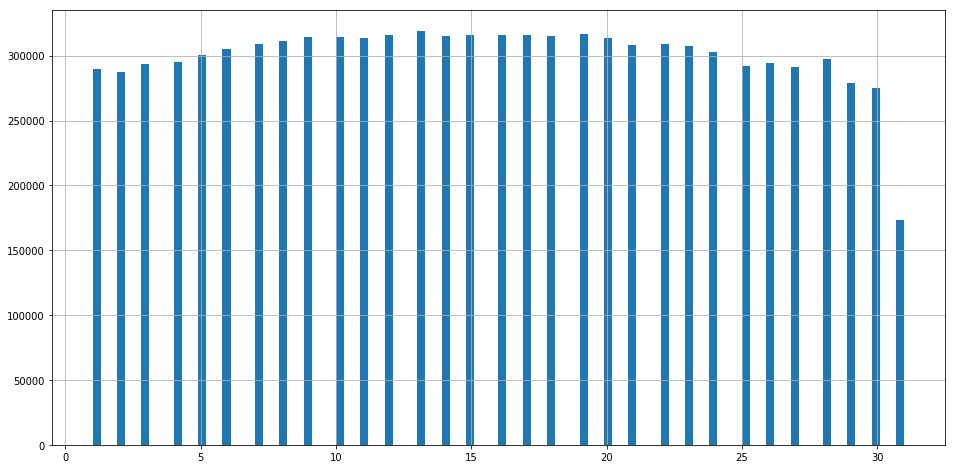

In [40]:
# Lets see if there is some relationship b/w the day of the week and number of rides taken.
# Usually more taxi's are booked during weekday.
data['day'].hist(bins=100, figsize=(16,8))
data['weekday'] = pd.to_datetime(data['pickup_datetime']).dt.weekday

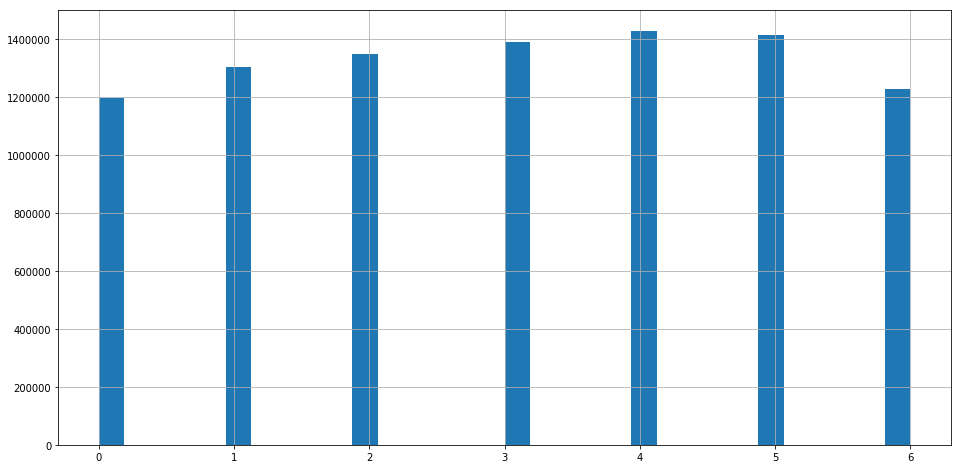

In [41]:
data['weekday'].hist(bins=32, figsize=(16,8))

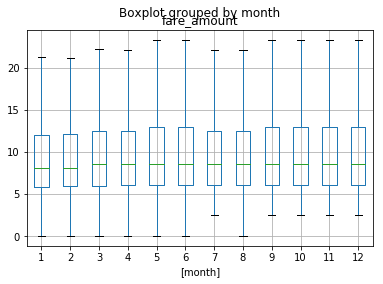

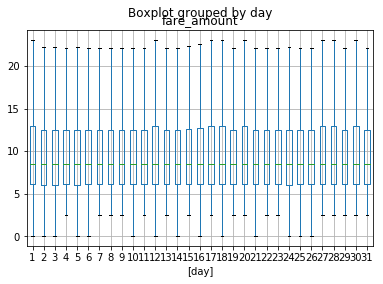

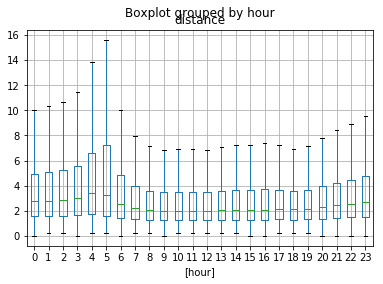

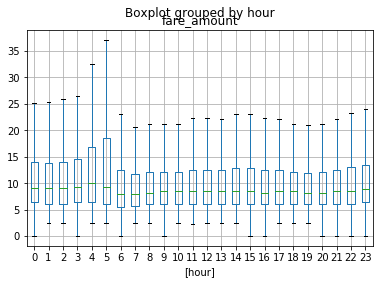

In [42]:
# Plotting boxplot to get information regarding the distribution of data . Plotting for
# 1.Finding out if there exist a relation between the hour of taxi pickup and fare amount
# 2.Finding out if there exist a relation between the month of taxi pickup and fare amount
# 3.Finding out if there exist a relation between the year of taxi pickup and fare amount

data[['fare_amount','month']].boxplot(by='month',showfliers=False)
data[['fare_amount','day']].boxplot(by='day',showfliers=False)
data[['distance','hour']].boxplot(by='hour',showfliers=False)
data[['fare_amount','hour']].boxplot(by='hour',showfliers=False)

# From the below plot we can see that the fare is quite high in the morning hours, this could be because of 
# airport rides as the same relation exist for the hour vs distance plot. Lets try to find if these rides are
# actually corresponding to airport pickups and drops.

In [43]:
# Here we check if the given cordinates of the pickup location or dropoff location is matching
# with the airports near the new york city. There are 3 airports near the city:
# 1. JFK 
# 2. Laguardia 
# 3. Newark
# Getting cordinates of these airports from the web
# JFK ->    Latitude: 40.6413111,   Longitude: -73.7781391
# LaG ->    Latitude: 40.77725,     Longitude: -73.872611
# Newark ->  Latitude: 40.6925,     Longitide: -74.168611


def get_is_airport_ride(column):
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = column
    jfk_airport = (40.6413, -73.778)
    lag_airport = (40.777, -73.872)
    newrk_airport = (40.692, -74.168)
    
    is_drop_at_jkf = (pickup_lat, pickup_lon, jfk_airport[0], jfk_airport[1] )
    is_drop_at_lag = (pickup_lat, pickup_lon, lag_airport[0], lag_airport[1] )
    is_drop_at_newrk = (pickup_lat, pickup_lon, newrk_airport[0], newrk_airport[1] )
    
    is_pickup_from_jkf = (jfk_airport[0], jfk_airport[1],dropoff_lat, dropoff_lon )
    is_pickup_from_lag = (lag_airport[0], lag_airport[1],dropoff_lat, dropoff_lon )
    is_pickup_from_newrk = (newrk_airport[0], newrk_airport[1], dropoff_lat, dropoff_lon)
    
    if(get_euclidean_dist(is_pickup_from_jkf) < 1 or get_euclidean_dist(is_pickup_from_lag) < 1 or 
       get_euclidean_dist(is_pickup_from_newrk) < 1 ):
        return 1
    if(get_euclidean_dist(is_drop_at_jkf) < 1 or get_euclidean_dist(is_drop_at_lag) < 1 or 
       get_euclidean_dist(is_drop_at_newrk) < 1 ):
        return 0
    
    return 0



In [44]:
# Adding a new feature, which will give us information about airport rides
# Based on this information, I plan to do further analysis on the pattern of long distance rides
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
data['is_airport_ride'] = data[columns].apply(get_is_airport_ride, axis=1)

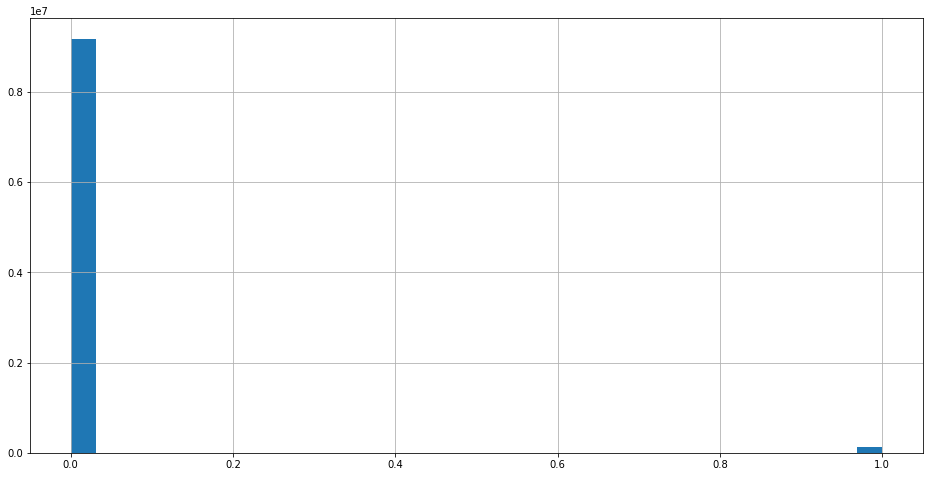

In [45]:
data['is_airport_ride'].hist(bins=32, figsize=(16,8))

Text(0.5,1,'Distance vs is_airport_ride')

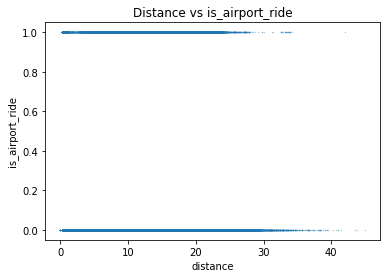

In [46]:
data.plot(kind='scatter',x='distance',y='is_airport_ride', s=0.2, alpha=0.4)
plt.title("Distance vs is_airport_ride")

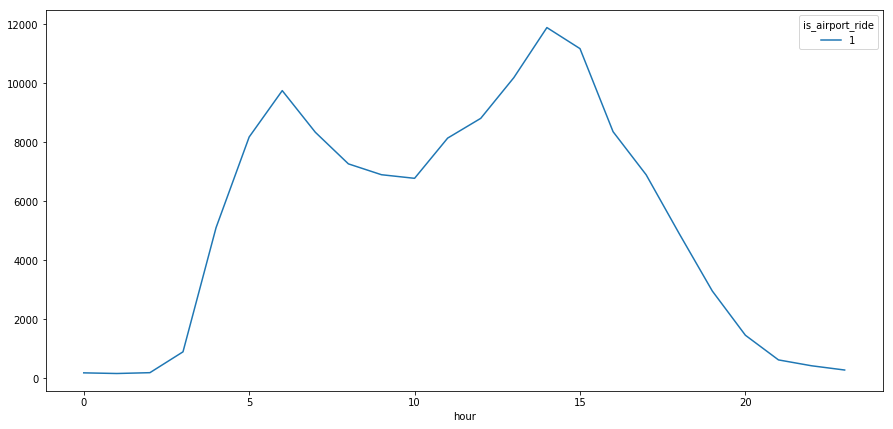

In [47]:
# Lets find out if there is something interesting we can do with the data we collected from the field is_airport_ride 
# and the hour of the day. This plot will help us analyze the airport taxi traffic throughout a day.
fig, ax = plt.subplots(figsize=(15,7))
data_airport = data[data['is_airport_ride'] > 0]
data_airport.groupby(['hour','is_airport_ride']).count()['key'].unstack().plot(ax=ax)

In [48]:
features_to_keep = ['pickup_latitude', 'pickup_longitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'hour', 'year','is_airport_ride']

In [49]:
train_data = data[features_to_keep]

In [50]:
train_data.head()

,pickup_latitude,pickup_longitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,year,is_airport_ride
0,40.721319,-73.844311,-73.841610,40.712278,1,1.030764,17,2009,0
1,40.711303,-74.016048,-73.979268,40.782004,1,8.450134,16,2010,0
2,40.761270,-73.982738,-73.991242,40.750562,2,1.389525,0,2011,0
3,40.733143,-73.987130,-73.991567,40.758092,1,2.799270,4,2012,0
4,40.768008,-73.968095,-73.956655,40.783762,1,1.999157,7,2010,0


In [51]:
output_data = data['fare_amount']

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train_data, output_data, test_size = 0.2, random_state=42)

In [54]:
linear_reg = LinearRegression()

In [55]:
linear_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [56]:
print(linear_reg.coef_)

[ 6.21710727e+00  1.64002304e+01 -1.49944810e+01 -1.05592095e+01
  3.46015120e-02  2.28005761e+00  1.36026274e-02  5.09205560e-01
  6.70096628e+00]


In [57]:
y_pred = linear_reg.predict(X_test)

In [58]:
rmse = np.sqrt(mean_squared_error(y_test , y_pred))
print("root mean Squared error: {}".format(rmse))

root mean Squared error: 3.202870444918603


In [59]:
test_data = pd.read_csv('test.csv')

In [60]:
test_data.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [61]:
test_data.count()

key                  9914
pickup_datetime      9914
pickup_longitude     9914
pickup_latitude      9914
dropoff_longitude    9914
dropoff_latitude     9914
passenger_count      9914
dtype: int64

In [62]:
# just like training data , we add the 'distance' field to the test data as part of preprocessing
columns = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude']
test_data['distance'] = test_data[columns].apply(get_euclidean_dist, axis=1)
test_data['is_airport_ride'] = test_data[columns].apply(get_is_airport_ride, axis=1)

In [63]:
# Making test data same as training data in terms of representation so that the model 
# doesn't complain.
test_data['hour'] = test_data.pickup_datetime.apply(lambda t: pd.to_datetime(t).hour)
test_data['year'] = test_data.pickup_datetime.apply(lambda t: pd.to_datetime(t).year)
# Keeping this as it is requiresd to be output in the submission.csv
test_data_with_key = test_data[['key'] + features_to_keep] 
test_data = test_data[features_to_keep]

In [64]:
test_data.head()

,pickup_latitude,pickup_longitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,hour,year,is_airport_ride
0,40.763805,-73.973320,-73.981430,40.743835,1,2.323260,13,2015,0
1,40.719383,-73.986862,-73.998886,40.739201,1,2.425353,13,2015,0
2,40.751260,-73.982524,-73.979654,40.746139,1,0.618628,11,2011,0
3,40.767807,-73.981160,-73.990448,40.751635,1,1.961033,21,2012,0
4,40.789775,-73.966046,-73.988565,40.744427,1,5.387301,21,2012,0


In [65]:
# Getting the prediction results from the linear regressor model and output it to the submission file
linear_reg.fit(train_data, output_data)
test_predictions = linear_reg.predict(test_data)

In [66]:
len(test_predictions)

9914

In [67]:
submission = pd.DataFrame(
    {'key': test_data_with_key.key, 'fare_amount': test_predictions},
    columns = ['key', 'fare_amount'])

In [68]:
submission.to_csv('submission.csv', index = False)

In [69]:
# Got a score of 5.35 with k-fold Linear regression 
# Now trying random Forest regressor to check if there is any improvement
from sklearn.ensemble import RandomForestRegressor
rfgModel = RandomForestRegressor()
# Trying cross validation first to check if the model is givibng good results. Root mean square value is
# a good approximation of the performance of a prediction model
print("Random Forest Generator Parameters: ")
print(rfgModel.get_params() )
rfgModel.fit(X_train, y_train)
rfgModel_pred = rfgModel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test , rfgModel_pred))
print("root mean Squared error: {}".format(rmse))
rfgModel.fit(train_data, output_data)
# Now running the model on actual data test data
rfgModel_pred = rfgModel.predict(test_data)

Random Forest Generator Parameters: 
{'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
root mean Squared error: 2.4442165252751806


In [70]:
submission = pd.DataFrame(
    {'key': test_data_with_key.key, 'fare_amount': rfgModel_pred},
    columns = ['key', 'fare_amount'])

In [71]:
submission.to_csv('submission.csv', index = False)